In [1]:
# Load in the Cerebellum

# Do the top 10% stuff here to show that they are fundamentally different in the aged mice

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad

In [2]:
adata_cer = sc.read_h5ad('/hpc/projects/group.quake/doug/Single_Nuc_Cerebellum/annotated_cerebellum.h5ad')

In [3]:
adata_cer.X = adata_cer.layers['counts'].copy()
adata_cer = adata_cer[adata_cer.obs.celltype == 'Microglia']

In [4]:
adata_cer

View of AnnData object with n_obs × n_vars = 478 × 31088
    obs: 'Sex', 'Age', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'celltype', 'sub1', 'sub2', 'sub3'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Age_colors', 'Sex_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'sub1_colors', 'sub3_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
#adata_cer.X = adata_cer.layers['counts'].copy()

sc.pp.filter_cells(adata_cer,min_genes=200)
sc.pp.filter_genes(adata_cer,min_cells=3)

sc.pp.log1p(adata_cer)
sc.pp.normalize_total(adata_cer,target_sum=1e4)

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [6]:
adata_cer

AnnData object with n_obs × n_vars = 478 × 18517
    obs: 'Sex', 'Age', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'celltype', 'sub1', 'sub2', 'sub3'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Age_colors', 'Sex_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'sub1_colors', 'sub3_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
mic = adata_cer[adata_cer.obs.celltype == 'Microglia']

In [8]:
score_genes = ['Cdk2', 'Cxcl2', 'Slamf9', 'Arhgap5', 'Ctss', 'Atp2a3', 'H2-K']

In [9]:
def score_and_split_by_percentile_per_age(
    adata_subset, 
    score_genes, 
    score_name="custom_score", 
    lower=10, 
    upper=90, 
    plot=True,
    save_pdf=None
):
    """
    Scores cells using a gene list, and returns bottom and top percentile cells
    computed separately within each age group.
    
    Parameters:
        adata_subset (AnnData): The input AnnData object (subsetted).
        score_genes (list): List of gene names to score cells with.
        score_name (str): Name of the score to be added to `.obs`.
        lower (float): Lower percentile cutoff (e.g. 10 for bottom 10%).
        upper (float): Upper percentile cutoff (e.g. 90 for top 10%).
        plot (bool): Whether to plot KDEs per age group.

    Returns:
        adata_low (AnnData): Cells in the bottom percentile (per age).
        adata_high (AnnData): Cells in the top percentile (per age).
    """

    # 1. Score cells
    sc.tl.score_genes(adata_subset, gene_list=score_genes, score_name=score_name)

    # 2. Create DataFrame for convenience
    df = adata_subset.obs[[score_name, 'Age']].copy()
    df['cell_index'] = df.index

    low_cells = []
    high_cells = []

    # 3. Group by Age and compute per-group percentiles
    for age, group in df.groupby('Age'):
        scores = group[score_name].values
        lower_val = np.percentile(scores, lower)
        upper_val = np.percentile(scores, upper)

        low_cells.extend(group[scores <= lower_val]['cell_index'].tolist())
        high_cells.extend(group[scores >= upper_val]['cell_index'].tolist())

        # Optional KDE plot per age
        if plot:
            plt.figure(figsize=(7, 4))
            sns.histplot(scores,bins=50, fill=True, color="lightblue", linewidth=2)
            plt.axvline(lower_val, color='red', linestyle='--', label=f'{lower}th %')
            plt.axvline(upper_val, color='green', linestyle='--', label=f'{upper}th %')
            plt.title(f'{score_name} Distribution - Age {age}')
            plt.xlabel(score_name)
            plt.ylabel('Density')
            plt.legend()
            plt.tight_layout()
            if save_pdf:
                plt.savefig(age+'_'+save_pdf,format='pdf')
            plt.show()

    # 4. Subset AnnData
    adata_low = adata_subset[low_cells].copy()
    adata_high = adata_subset[high_cells].copy()

    return adata_low, adata_high

def score_and_split_by_percentile(
    adata_subset, 
    score_genes, 
    score_name="custom_score", 
    lower=10, 
    upper=90, 
    plot=True,
    save_pdf=None
):
    """
    Scores cells using a gene list, and returns bottom and top percentile cells
    computed separately within each age group.
    
    Parameters:
        adata_subset (AnnData): The input AnnData object (subsetted).
        score_genes (list): List of gene names to score cells with.
        score_name (str): Name of the score to be added to `.obs`.
        lower (float): Lower percentile cutoff (e.g. 10 for bottom 10%).
        upper (float): Upper percentile cutoff (e.g. 90 for top 10%).
        plot (bool): Whether to plot KDEs per age group.

    Returns:
        adata_low (AnnData): Cells in the bottom percentile (per age).
        adata_high (AnnData): Cells in the top percentile (per age).
    """

    # 1. Score cells
    sc.tl.score_genes(adata_subset, gene_list=score_genes, score_name=score_name)

    # 2. Create DataFrame for convenience
    df = adata_subset.obs[[score_name, 'Age']].copy()
    df['cell_index'] = df.index

    low_cells = []
    high_cells = []

    # 3. Group by Age and compute per-group percentiles
    scores = df[score_name].values
    lower_val = np.percentile(scores, lower)
    upper_val = np.percentile(scores, upper)

    low_cells.extend(df[scores <= lower_val]['cell_index'].tolist())
    high_cells.extend(df[scores >= upper_val]['cell_index'].tolist())

        # Optional KDE plot per age
    if plot:
        plt.figure(figsize=(7, 4))
        sns.histplot(scores, fill=True, color="lightblue", linewidth=2,bins=50)
        plt.axvline(lower_val, color='red', linestyle='--', label=f'{lower}th %')
        plt.axvline(upper_val, color='green', linestyle='--', label=f'{upper}th %')
        plt.title(f'{score_name} Distribution')
        plt.xlabel(score_name)
        plt.ylabel('Density')
        plt.legend()
        plt.tight_layout()
        if save_pdf:
            plt.savefig(save_pdf,format='pdf')
        plt.show()

    # 4. Subset AnnData
    adata_low = adata_subset[low_cells].copy()
    adata_high = adata_subset[high_cells].copy()

    return adata_low, adata_high

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


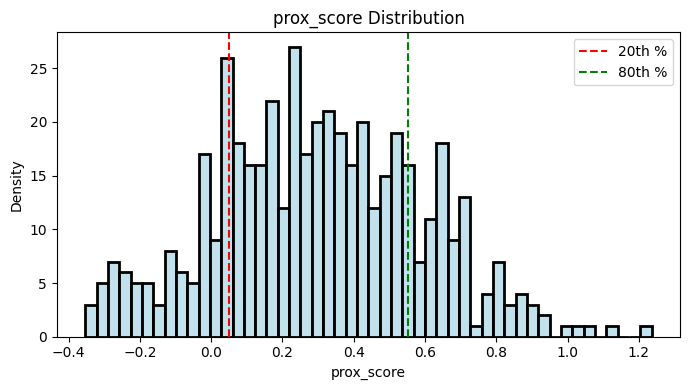

In [10]:
CB_far, CB_gran_assoc = score_and_split_by_percentile(mic, score_genes, score_name="prox_score", lower=20, upper=80, plot=True,save_pdf = 'full_dataset_mouse_scores.pdf')

In [11]:
#CB_far, CB_gran_assoc = score_and_split_by_percentile_per_age(mic, score_genes, score_name="prox_score", lower=20, upper=80, plot=True,save_pdf = 'full_dataset_mouse_scores.pdf')

In [12]:
from adjustText import adjust_text
def shift_log_normalized(adata):
    """
    Shift log-normalized values to be non-negative.
    
    Parameters:
    adata : AnnData
        Annotated data matrix.
    
    Returns:
    AnnData
        AnnData object with shifted log-normalized values.
    """
    adata_copy = adata.copy()
    min_val = adata_copy.X.min()
    if min_val < 0:
        adata_copy.X = adata_copy.X - min_val
    return adata_copy

def differential_expression(adata1, adata2, shift_log_values=False):
    """
    Perform differential expression analysis between two AnnData objects.

    Parameters:
    adata1 : AnnData
        First annotated data matrix.
    adata2 : AnnData
        Second annotated data matrix.
    shift_log_values : bool
        Whether to shift log-normalized values to be non-negative.

    Returns:
    pd.DataFrame
        DataFrame containing differential expression results.
    """
    # Add a column indicating the origin of each cell
    adata1.obs['group'] = 'group1'
    adata2.obs['group'] = 'group2'

    if shift_log_values:
        adata1 = shift_log_normalized(adata1)
        adata2 = shift_log_normalized(adata2)

    # Concatenate the two AnnData objects
    adata_combined = adata1.concatenate(adata2, batch_key='batch', batch_categories=['group1', 'group2'])

    # Perform differential expression analysis using Scanpy
    sc.tl.rank_genes_groups(adata_combined, groupby='batch', reference='group1', method='wilcoxon',use_raw=False)

    # Extract results into a DataFrame
    results = adata_combined.uns['rank_genes_groups']
    groups = results['names'].dtype.names
    pvals = pd.DataFrame({group + '_pvals': results['pvals'][group] for group in groups})
    pvals_adj = pd.DataFrame({group + '_pvals_adj': results['pvals_adj'][group] for group in groups})
    logfoldchanges = pd.DataFrame({group + '_logfoldchanges': results['logfoldchanges'][group] for group in groups})
    names = pd.DataFrame({group + '_names': results['names'][group] for group in groups})

    return pd.concat([names, pvals, pvals_adj, logfoldchanges], axis=1)

def plot_volcano(
    df, 
    sig_lfc=0.5, 
    group='group2', 
    pval_col_suffix='_pvals', 
    logfc_col_suffix='_logfoldchanges', 
    name_col_suffix='_names', 
    title='Volcano Plot', 
    xlims=None, 
    savefig=None,
    figsize=(10, 6)
):
    """
    Plot a volcano plot for differential expression analysis results.

    Parameters:
    df : pd.DataFrame
        DataFrame containing differential expression results.
    group : str
        Group name for differential expression results.
    pval_col_suffix : str
        Suffix for the p-value column in the DataFrame.
    logfc_col_suffix : str
        Suffix for the log fold change column in the DataFrame.
    name_col_suffix : str
        Suffix for the gene names column in the DataFrame.
    title : str
        Title for the plot.
    xlims : tuple, optional
        Limits for the x-axis.
    savefig : str, optional
        Path to save the figure.

    Returns:
    list, list
        Two lists containing significant genes with log fold change < 1 and > 1, ordered by log fold change.
    """
    pvals = df[group + pval_col_suffix]
    logfoldchanges = df[group + logfc_col_suffix]
    gene_names = df[group + name_col_suffix]
    
    # Define significance thresholds
    sig_pval = 0.05
    sig_logfc = sig_lfc
    
    # Create the plot
    plt.figure(figsize=figsize)
    plt.scatter(logfoldchanges, -np.log10(pvals), color='grey', alpha=0.5, label='NS')
    
    # Highlight significant points
    sig_points = (pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)
    plt.scatter(logfoldchanges[sig_points], -np.log10(pvals[sig_points]), color='red', alpha=0.50, label='P-value and log2 FC')
    plt.scatter(logfoldchanges[(pvals < sig_pval) & ~sig_points], -np.log10(pvals[(pvals < sig_pval) & ~sig_points]), color='blue', alpha=0.50, label='P-value')
    plt.scatter(logfoldchanges[~(pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)], -np.log10(pvals[~(pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)]), color='green', alpha=0.50, label='Log2 FC')
    
    plt.axhline(y=-np.log10(sig_pval), color='black', linestyle='--')
    plt.axvline(x=sig_logfc, color='black', linestyle='--')
    plt.axvline(x=-sig_logfc, color='black', linestyle='--')
    
    # Annotate significant genes
    texts = []
    sig_genes_less_than_1 = []  # List for significant genes with logFC < -1
    sig_genes_greater_than_1 = []  # List for significant genes with logFC > 1

    for i in range(len(gene_names)):
        if sig_points[i]:
            if logfoldchanges[i] < -1 * sig_lfc:
                sig_genes_less_than_1.append((gene_names[i], logfoldchanges[i]))  # Store the gene and its logFC
            elif logfoldchanges[i] > sig_lfc:
                sig_genes_greater_than_1.append((gene_names[i], logfoldchanges[i]))  # Store the gene and its logFC

            texts.append(plt.text(logfoldchanges[i], -np.log10(pvals[i]), gene_names[i], fontsize=8))
    
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
    
    plt.xlabel('Log2 fold change')
    plt.ylabel('-Log10 P-value')
    plt.title(title)
    plt.legend(loc='best')
    
    if xlims is not None:
        plt.xlim(xlims)
        
    if savefig is not None:
        plt.savefig(savefig, format='pdf')
        
    plt.show()
    
    # Sort the lists by the absolute value of log fold change
    sig_genes_less_than_1 = sorted(sig_genes_less_than_1, key=lambda x: abs(x[1]), reverse=True)
    sig_genes_greater_than_1 = sorted(sig_genes_greater_than_1, key=lambda x: abs(x[1]), reverse=True)

    # Extract only the gene names after sorting
    sig_genes_less_than_1 = [gene for gene, logfc in sig_genes_less_than_1]
    sig_genes_greater_than_1 = [gene for gene, logfc in sig_genes_greater_than_1]
    
    return sig_genes_less_than_1, sig_genes_greater_than_1

/tmp/ipykernel_820183/572351752.py:37: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata1.obs['group'] = 'group1'
/tmp/ipykernel_820183/572351752.py:38: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2.obs['group'] = 'group2'
/tmp/ipykernel_820183/572351752.py:45: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata1.concatenate(adata2, batch_key='batch', batch_categories=['group1', 'group2'])


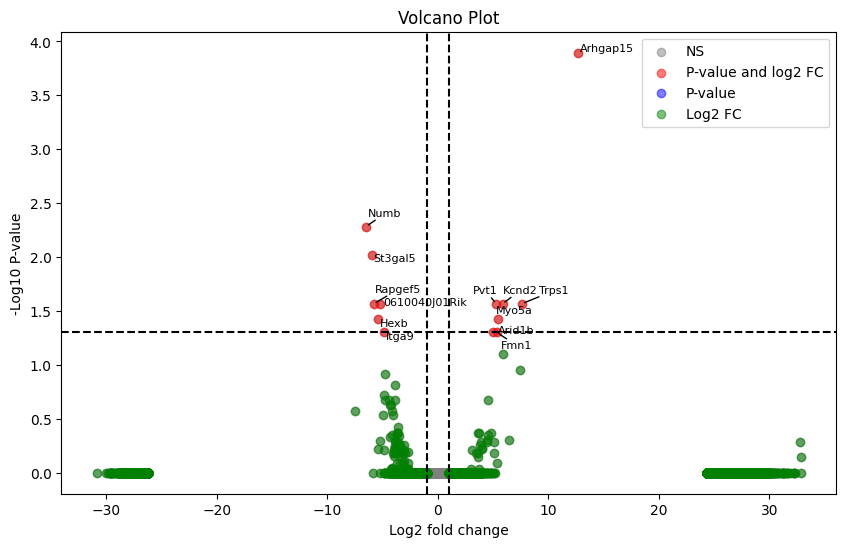

In [13]:
df_assoc = differential_expression(CB_gran_assoc[CB_gran_assoc.obs.Age == '3m'], CB_gran_assoc[CB_gran_assoc.obs.Age == '24m'])
CB_far_genes, CB_assoc_genes = plot_volcano(df_assoc, pval_col_suffix='_pvals_adj',sig_lfc=1)

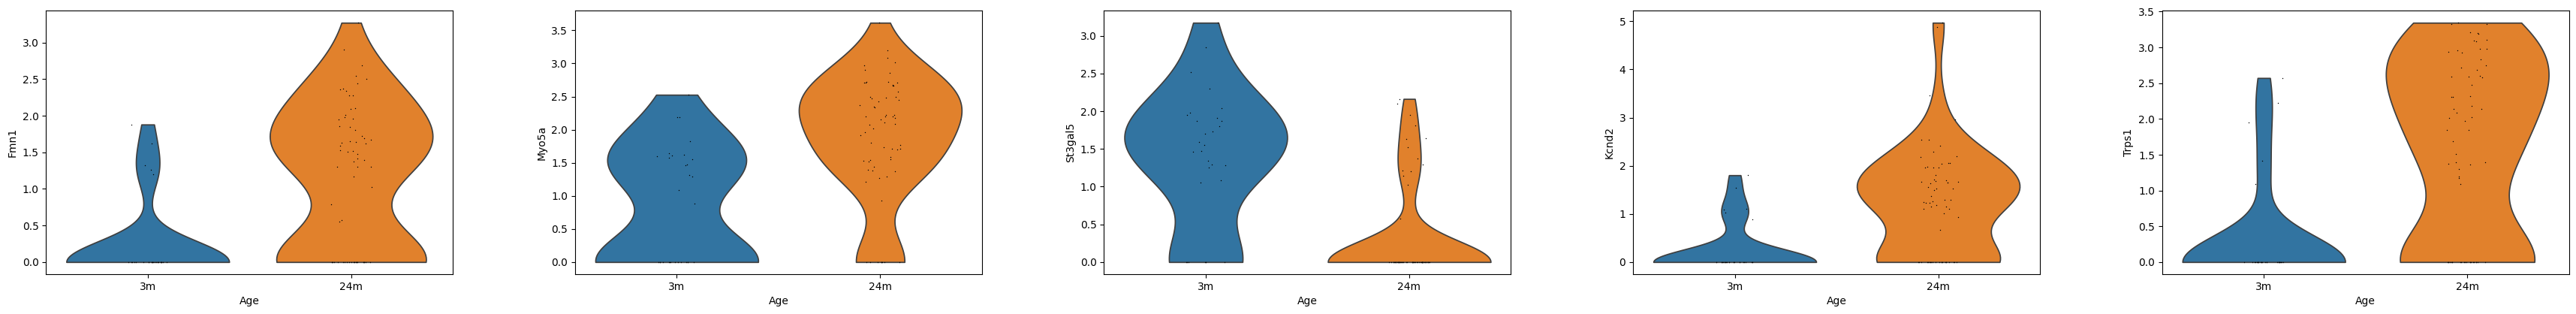

In [14]:
sc.pl.violin(CB_gran_assoc, keys=['Fmn1','Myo5a','St3gal5','Kcnd2','Trps1'], groupby='Age',save='gran_assoc_differences.pdf')

In [15]:
LDAM = ['Slc25a5', 'Npl', 'Angptl7','Pde2a','Ldhb','Cd63','Sepp1','Sdcbp','Adipor1','Rbbp4','Cndp2','Hsd17b4','Gpd11','Dazap2','Hnmpk','Rapsn','Cat','Kl','Nampt','Acsl1','Dpyd','Cd163']
neurop_full = ['Axl','Cd9','Csf1r','Hif1a','Itgax','Tmem163','Apoe','Cybb','Lilr4b','Lgals3']

sc.tl.score_genes(CB_gran_assoc, gene_list=LDAM, score_name='LDAM')
sc.tl.score_genes(CB_gran_assoc, gene_list=neurop_full, score_name='resilience')

In [16]:
def violin_temp_categorical(adata, key, groupby, run_stats=False, stripplot=False, **kwargs):
    """
    Wrapper around sc.pl.violin that temporarily converts the groupby column to categorical
    without modifying the original AnnData object. Optionally, it performs pairwise Wilcoxon 
    rank-sum tests between the conditions and produces a strip plot with a regression line 
    and confidence intervals.
    
    Parameters:
        adata (AnnData): Your AnnData object.
        key (str): Key in `.obs` to plot (should be numeric for the regression plot).
        groupby (str): Column in `.obs` to group by (will be treated as categorical).
        run_stats (bool): If True, compute pairwise Wilcoxon rank-sum tests.
        stripplot (bool): If True, create a strip plot with a regression line and confidence intervals.
        kwargs: Other keyword arguments passed to `sc.pl.violin`.
    """
    import pandas as pd
    import itertools
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import ranksums  # using ranksums for the rank-sum test
    
    # Create a shallow copy to avoid modifying the original AnnData
    temp_adata = adata.copy()
    temp_adata.obs[groupby] = pd.Categorical(temp_adata.obs[groupby])
    
    # Plot the violin plot using Scanpy
    sc.pl.violin(temp_adata, keys=key, groupby=groupby, **kwargs)
    
    # Run pairwise statistics if the flag is True
    if run_stats:
        groups = temp_adata.obs[groupby].cat.categories
        stats_results = {}
        for grp1, grp2 in itertools.combinations(groups, 2):
            data1 = temp_adata.obs.loc[temp_adata.obs[groupby] == grp1, key]
            data2 = temp_adata.obs.loc[temp_adata.obs[groupby] == grp2, key]
            stat, p_value = ranksums(data1, data2)
            stats_results[(grp1, grp2)] = {'statistic': stat, 'p-value': p_value}
        
        print("Pairwise Wilcoxon rank-sum test results:")
        for groups_pair, res in stats_results.items():
            print(f"{groups_pair[0]} vs {groups_pair[1]}: statistic = {res['statistic']:.3f}, p-value = {res['p-value']:.3e}")
    
    # Create a strip plot with a regression line if the flag is True
    if stripplot:
        # Ensure the key column is numeric
        if not pd.api.types.is_numeric_dtype(temp_adata.obs[key]):
            print(f"Column '{key}' is not numeric. Regression plot requires numeric data.")
        else:
            # Map categorical groups to numeric codes for regression
            temp_adata.obs['_group_code'] = temp_adata.obs[groupby].cat.codes
        
            # Fit regression using numpy to get the coefficients
            x_vals = temp_adata.obs['_group_code']
            y_vals = temp_adata.obs[key]
            slope, intercept = np.polyfit(x_vals, y_vals, 1)
            equation = f"y = {slope:.2f}x + {intercept:.2f}"

            # Plotting
            plt.figure(figsize=(8, 6))
            sns.stripplot(x=groupby, y=key, data=temp_adata.obs, jitter=True, color='gray', alpha=0.5)
            sns.regplot(x='_group_code', y=key, data=temp_adata.obs, scatter=False, ci=95, color='red', label=equation)

            # Set x-axis ticks to original category labels
            plt.xticks(ticks=range(len(temp_adata.obs[groupby].cat.categories)),
                   labels=temp_adata.obs[groupby].cat.categories)
            plt.xlabel(groupby)
            plt.title("Strip Plot with Best Fit Line and 95% Confidence Interval")
            plt.legend(title="Regression Line", loc="best")
            plt.savefig('strip_with_line.pdf')
            plt.show()

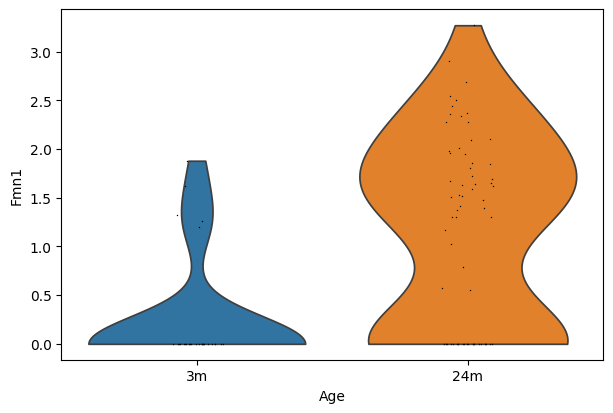

In [17]:
violin_temp_categorical(CB_gran_assoc,"Fmn1",groupby='Age',run_stats=False,stripplot=False,save='Fmn1_violin_plot.pdf')

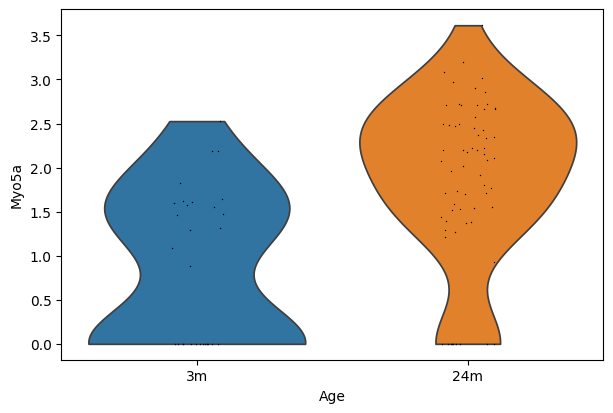

In [18]:
violin_temp_categorical(CB_gran_assoc,"Myo5a",groupby='Age',run_stats=False,stripplot=False,save='Myo5a_violin_plot.pdf')

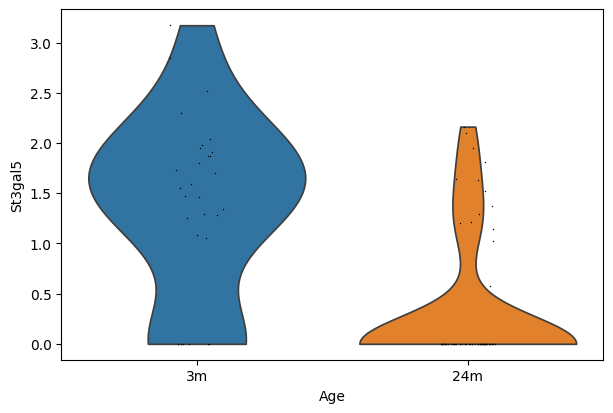

In [19]:
violin_temp_categorical(CB_gran_assoc,"St3gal5",groupby='Age',run_stats=False,stripplot=False,save='St3gal5_violin_plot.pdf')

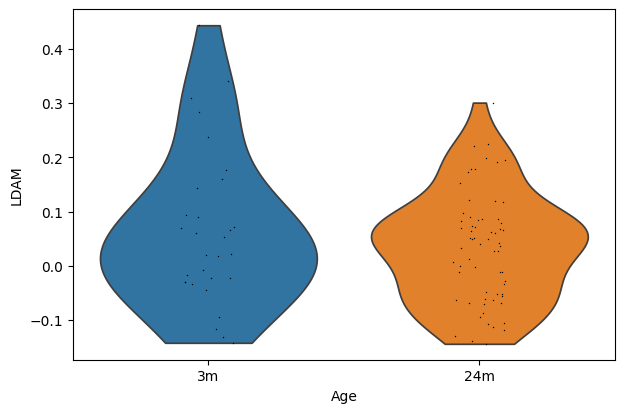

Pairwise Wilcoxon rank-sum test results:
3m vs 24m: statistic = 0.640, p-value = 5.220e-01


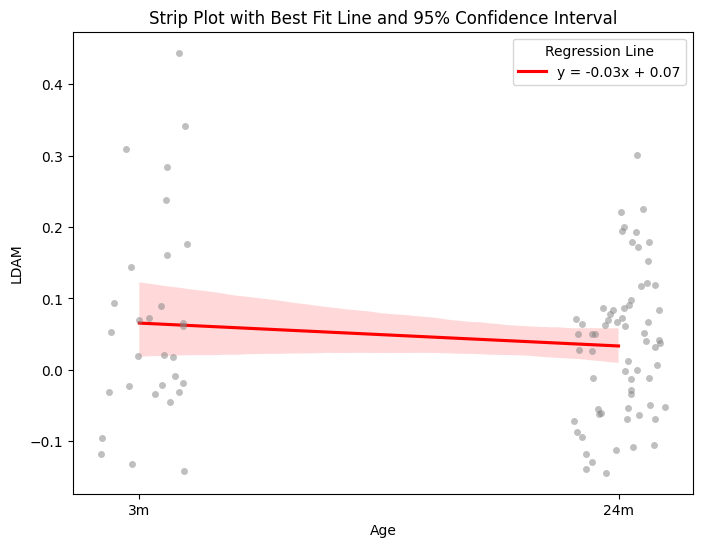

In [20]:
violin_temp_categorical(CB_gran_assoc,"LDAM",groupby='Age',run_stats=True,stripplot=True,save='LDAM_violin_plot.pdf')

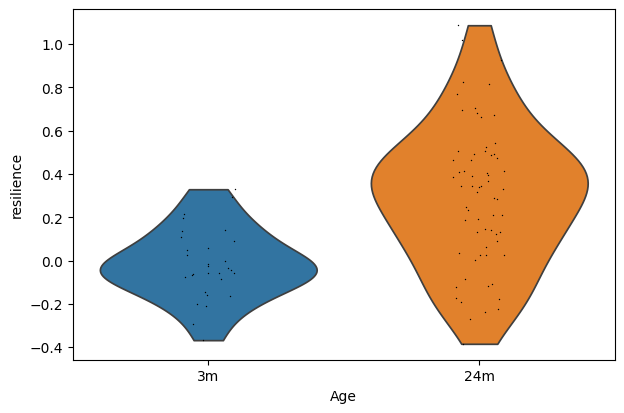

Pairwise Wilcoxon rank-sum test results:
3m vs 24m: statistic = -4.640, p-value = 3.485e-06


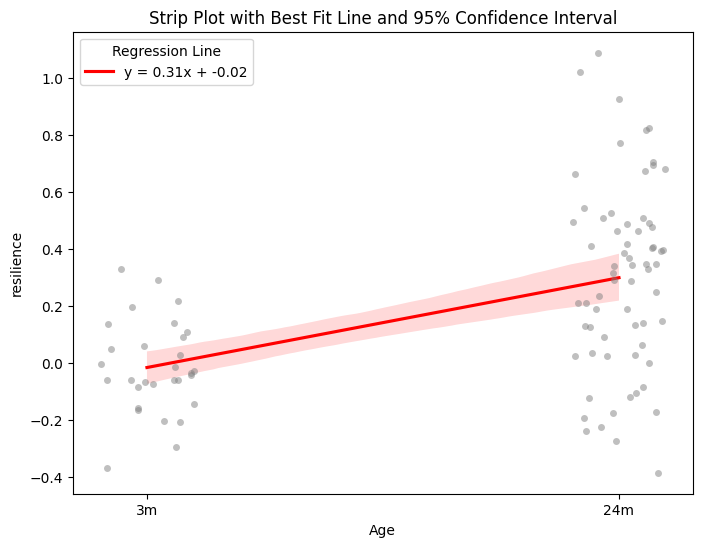

In [21]:
violin_temp_categorical(CB_gran_assoc,"resilience",groupby='Age',run_stats=True,stripplot=True,save='resilience_violin_plot.pdf')